In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd /content/gdrive/MyDrive/CS271P_project

/content/gdrive/MyDrive/CS271P_project


In [ ]:
!ls

1m_tweets.csv  data.csv  final_dataset.csv  glove  Suicide_Detection.csv


In [ ]:
import pandas as pd
import re
import string
from wordcloud import WordCloud
from textblob import TextBlob, Word
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

tweets = pd.read_csv('final_dataset.csv', encoding="utf-8")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def remove_unnecessary_data_from(tweets):
    refined_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # Converting to lowercase
        tweet = tweet.lower()
        # Remove unnecessary things like mentions and hashtags
        tweet = re.sub('@[^ ]+|#[^ ]+', '', tweet)
        # Remove punctuation
        tweet = tweet.replace('[^A-Za-z0-9 ]', "")
        # Lemmatize all the words
        tweet = " ".join([Word(word).lemmatize() for word in tweet.split()])
        refined_tweets.append(tweet)
    return refined_tweets

In [ ]:
X = remove_unnecessary_data_from([tweet for tweet in tweets['text']])

In [ ]:
from keras.preprocessing.text import Tokenizer 
MAX_NUM_WORDS = 1000
tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)

In [ ]:
word_vector = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

15097

In [ ]:
train_data, test_data = train_test_split(tweets, test_size=0.2, random_state=42)
len_val_data = len(test_data)//2
val_data = test_data[:len_val_data]
test_data = test_data[len_val_data:]
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))
print("Val Data size", len(val_data))

Train Data size: 10668
Test Data size 1334
Val Data size 1334


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 50

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(tokenizer.texts_to_sequences(val_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
print("Validation X Shape:",x_val.shape)

Training X Shape: (10668, 50)
Testing X Shape: (1334, 50)
Validation X Shape: (1334, 50)


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

y_train = encoder.transform(train_data.label.to_list())
y_test = encoder.transform(test_data.label.to_list())
y_val = encoder.transform(val_data.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

y_train shape: (10668, 1)
y_test shape: (1334, 1)
y_val shape: (1334, 1)


In [ ]:
GLOVE_EMB = 'glove/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 512
EPOCHS = 10

In [ ]:
import numpy as np

embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
21/21 [==============================] - 27s 993ms/step - loss: 0.4499 - accuracy: 0.7953 - val_loss: 0.1739 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - 20s 966ms/step - loss: 0.1842 - accuracy: 0.9296 - val_loss: 0.1130 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - 20s 956ms/step - loss: 0.1167 - accuracy: 0.9584 - val_loss: 0.0979 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 4/10
21/21 [==============================] - 20s 969ms/step - loss: 0.0874 - accuracy: 0.9689 - val_loss: 0.0953 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 5/10
21/21 [==============================] - 20s 975ms/step - loss: 0.0728 - accuracy: 0.9749 - val_loss: 0.0795 - val_accuracy: 0.9715 - lr: 0.0010
Epoch 6/10
21/21 [==============================] - 20s 978ms/step - loss: 0.0567 - accuracy: 0.9801 - val_loss: 0.0935 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 7/10
21/21 [==============================] - 20s 953ms/st

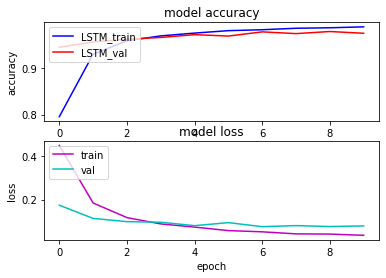

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(x_val, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 1s 1s/step


In [ ]:
print('accuracy %s' % accuracy_score(y_pred_1d, list(val_data.label)))
print(classification_report(list(val_data.label), y_pred_1d, digits=5))

accuracy 0.9887556221889056
              precision    recall  f1-score   support

           0    0.98401   0.99413   0.98904       681
           1    0.99381   0.98315   0.98845       653

    accuracy                        0.98876      1334
   macro avg    0.98891   0.98864   0.98875      1334
weighted avg    0.98881   0.98876   0.98875      1334

